# Actual stuff

Launch two terminals from the main tree.

In [1]:
# get some basic os functions
import os
import glob
# import our parallel processing framework
import dask
import dask.multiprocessing
from dask.diagnostics import ProgressBar
import distributed
from distributed.diagnostics import progress
# numpy and plotting
import numpy as np
from itertools import accumulate
from operator import matmul
%matplotlib inline
import matplotlib.pyplot as plt
# image reading and writing
from skimage.external import tifffile as tif
#
import seaborn as sns
# load our actual registration functions
from imreg_dph import *
# monkey patch in numpy's fft, pyfftw doesn't play nice with the cluster
import imreg_dph
imreg_dph.fft2 = np.fft.fft2
imreg_dph.ifft2 = np.fft.ifft2
imreg_dph.fftshift = np.fft.fftshift

if running on the cluster we need to start our scheduler:

    dask-scheduler --scheduler-file /groups/betzig/home/hoffmand/dask-scheduler.json

this should be done on the same computer that's running this notebook (not windows, use login1 or login2 or
 a qlogin interactive session on the cluster)
 
You can now open up a status window [http://[all ip addresses on host]:8787](http://localhost:8787)

In [2]:
# if running on cluster we need to start our workers
!qsub -pe batch 32 -t 1-32 -b y -j y -o ./dask-log.log -cwd -V dask-worker --scheduler-file /groups/betzig/home/hoffmand/dask-scheduler.json

Your job-array 20274135.1-32:1 ("dask-worker") has been submitted


In [75]:
# if running on the cluster we need to attached to the scheduler
client = distributed.Client(scheduler_file="/groups/betzig/home/hoffmand/dask-scheduler.json")

In [3]:
# change this if needed
paths = sorted(glob.iglob("/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_*_InLens/*.tif"))
len(paths)

23749

In [4]:
# generate a list of pairs to register together
pairs = [(paths[i], paths[i + 1]) for i in range(len(paths) - 1)]
pairs[:4]

[('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000030_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000133_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000133_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000237_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000237_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000340_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D

In [5]:
def load_and_register(path0, path1, method=register_translation, *args, **kwargs):
    """Load two images defined by path0 and path1 (assumed to be tif) and register with meth
    
    Parameters
    ----------
    path0 : URI to data0
    path1 : URI to data1
    method : callable
        the registration algortithm
    args : args passed to meth
    kwargs : kwargs passed to meth
    
    Returns
    -------
    af : AffineTransformation
        The affine transformation that registers path1 to path0
    """
    data0 = tif.imread(path0)
    data1 = tif.imread(path1)
    
    return method(data0, data1, *args, **kwargs)

In [7]:
# test the registration and time it
%time af = load_and_register(*pairs[0], register_translation)
print(af)

CPU times: user 14.6 s, sys: 1.61 s, total: 16.3 s
Wall time: 6.13 s
<AffineTransform: translation = [-1.87 -3.35], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [8]:
to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_translation) for path0, path1 in pairs])
sub_res = client.compute(to_compute)
progress(sub_res)

NameError: name 'progress' is not defined

In [10]:
progress(sub_res)

In [8]:
# Now we can propagate the transformations throughout the whole stack.
def plot_af_accum(results):
    results2 = list(accumulate(results, matmul))

    # and plot the results
    fig, axs = plt.subplots(2,2, figsize=(9,9), sharex=True)
    axs = axs.flatten()
    axs[0].plot(np.array([result.translation for result in results2]))
    axs[3].plot(np.rad2deg(np.array([result.rotation for result in results2])))
    axs[1].plot((np.array([result.scale for result in results2])))
    axs[2].plot(np.rad2deg(np.array([result.shear for result in results2])))

    axs[0].set_title("translation")
    axs[3].set_title("rotation")
    axs[1].set_title("scale")
    axs[2].set_title("shear")

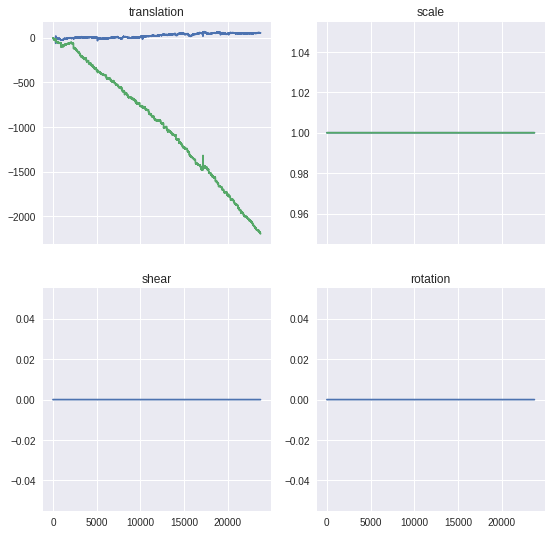

In [15]:
results_register_translation = sub_res.result()
plot_af_accum(results_register_translation)

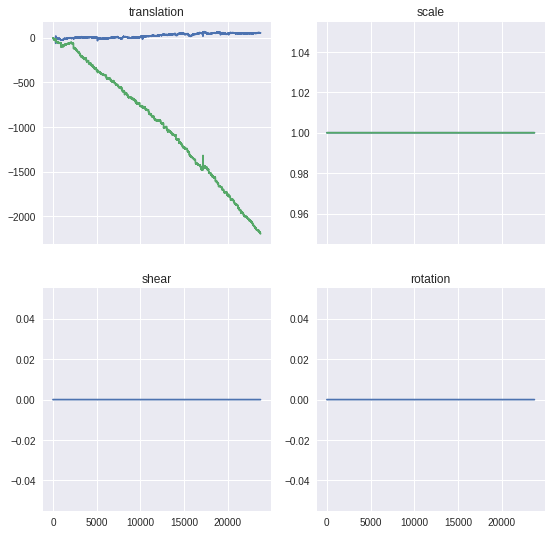

In [9]:
results_register_translation = [AffineTransform(d) for d in np.load("results_register_translation.npy")]
plot_af_accum(results_register_translation)

In [45]:
# we can save the results in a numpy array
np.save("results_register_translation.npy", np.array([result.params for result in results_register_translation]))

In [104]:
results_register_translation_accum = list(accumulate([AffineTransform(np.eye(3))] + results_register_translation, matmul))

In [103]:
def load_transform_avg(paths, afs, shape, filename):
    data = np.array([tif.imread(path) for path in paths])
    data_warp = np.array([cv_warp(im, af, shape) for im, af in zip(data, afs)])
    tif.imsave(filename, data_warp.mean(0).astype(data.dtype))

In [105]:
paths_arr = np.array(paths)
afs_array = np.array(results_register_translation_accum)

In [106]:
paths_arr.shape

(23749,)

In [107]:
afs_array.shape

(23749,)

In [108]:
os.mkdir("/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Test Align")

In [110]:
mydir = "/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Test Align/"

In [127]:
to_compute = dask.delayed([dask.delayed(load_transform_avg, pure=True)(p, a, (5000, 11000), mydir + "{:05d}.tif".format(i))
                          for i, (p, a) in enumerate(zip(paths_arr[:-1].reshape(-1, 4), afs_array[:-1].reshape(-1, 4)))
                          ])

In [128]:
sub_res = client.compute(to_compute)
progress(sub_res)

Widget Javascript not detected.  It may not be installed or enabled properly.
